In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pickle
import matplotlib.pyplot as plt

In [ ]:
TestData = pd.read_csv('/content/drive/MyDrive/NLP/clean_test.csv')
TrainData = pd.read_csv('/content/drive/MyDrive/NLP/clean_train.csv')
print(TestData.shape)
print(TrainData.shape)

(7968, 2)
(45149, 2)


In [ ]:
labels = TrainData['Y'].unique()
label_map = {label: idx for idx, label in enumerate(labels)}
TrainData['Y'] = TrainData['Y'].map(label_map)
# one-hot encoding
cat_labels = to_categorical(TrainData['Y'], num_classes=len(labels))

In [ ]:
texts = np.array(TrainData['X'])
train_sentences, val_sentences, train_labels, val_labels = train_test_split(texts, cat_labels, test_size=0.25, random_state=42)
# Calculate max length of sequences
max_len = round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

#TextVectorization layer
max_vocab_len = 10000
text_vector = layers.experimental.preprocessing.TextVectorization(
    max_tokens=max_vocab_len,
    output_mode='int',
    output_sequence_length=max_len
)
text_vector.adapt(train_sentences)

#Embedding layer
embedding = layers.Embedding(
    input_dim=max_vocab_len,
    output_dim=256,
    input_length=max_len
)

#main model of LSTM network
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vector(inputs)
x = embedding(x)
x = layers.SpatialDropout1D(0.8)(x)
x = layers.Bidirectional(layers.LSTM(300, kernel_regularizer=regularizers.l2(0.001)))(x)  # Single LSTM layer with 128 units
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)  # Additional Dense layer
x = layers.Dropout(0.5)(x)
#x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
outputs = layers.Dense(len(labels), activation='softmax')(x)



In [ ]:
lstm = tf.keras.Model(inputs, outputs, name='LSTM_MODEL')
lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
lstm_history = lstm.fit(train_sentences, train_labels, epochs=20, batch_size=32, validation_data=(val_sentences, val_labels), callbacks=[early_stopping])
# Save the model
lstm.save('/content/drive/MyDrive/NLP/lstm_model', save_format='tf')
with open('/content/drive/MyDrive/NLP/lstm_history.pkl', 'wb') as file:
    pickle.dump(lstm_history.history, file)

Epoch 1/20
1059/1059 [==============================] - 52s 41ms/step - loss: 2.2581 - accuracy: 0.3766 - val_loss: 1.9108 - val_accuracy: 0.4579
Epoch 2/20
1059/1059 [==============================] - 24s 23ms/step - loss: 1.8915 - accuracy: 0.4646 - val_loss: 1.8414 - val_accuracy: 0.4586
Epoch 3/20
1059/1059 [==============================] - 21s 20ms/step - loss: 1.7944 - accuracy: 0.4839 - val_loss: 1.7962 - val_accuracy: 0.4765
Epoch 4/20
1059/1059 [==============================] - 20s 19ms/step - loss: 1.7363 - accuracy: 0.4964 - val_loss: 1.7907 - val_accuracy: 0.4788
Epoch 5/20
1059/1059 [==============================] - 19s 18ms/step - loss: 1.6907 - accuracy: 0.5077 - val_loss: 1.7904 - val_accuracy: 0.4755
Epoch 6/20
1059/1059 [==============================] - 19s 18ms/step - loss: 1.6478 - accuracy: 0.5275 - val_loss: 1.7807 - val_accuracy: 0.4957
Epoch 7/20
1059/1059 [==============================] - 19s 18ms/step - loss: 1.6075 - accuracy: 0.5418 - val_loss: 1.7800 -

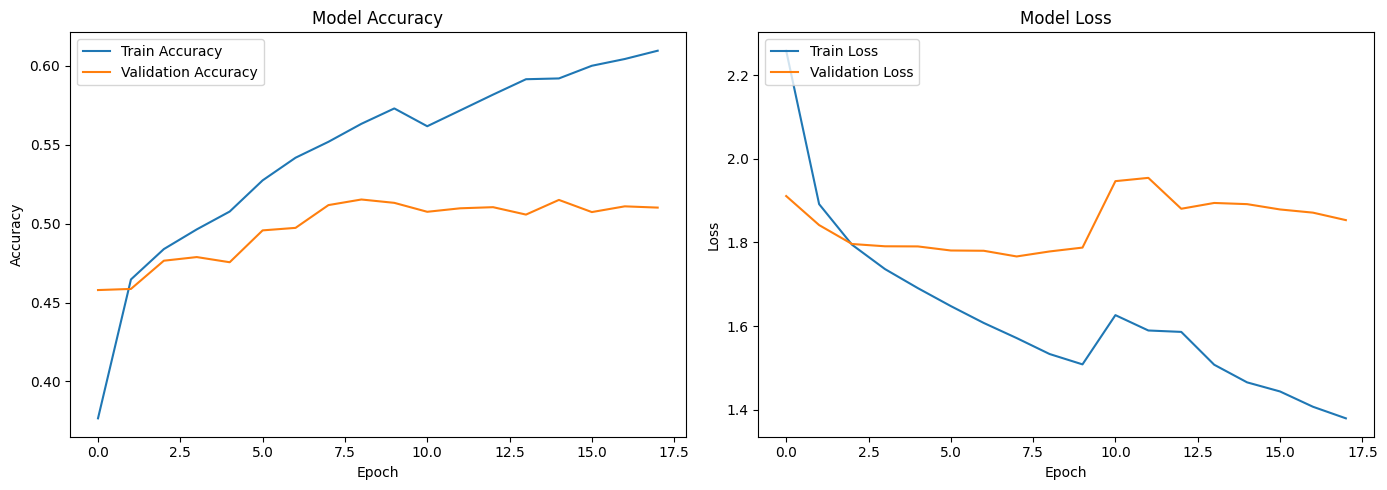

In [ ]:
def plot_training_history(history_file):
    # Load the training history
    with open(history_file, 'rb') as file:
        history = pickle.load(file)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history('/content/drive/MyDrive/NLP/lstm_history.pkl')

249/249 [==============================] - 2s 7ms/step - loss: 1.8224 - accuracy: 0.4874
Test Loss: 1.8223505020141602
Test Accuracy: 0.4874497950077057
249/249 [==============================] - 2s 6ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.48744979919678716
F1 Score: 0.41216515097282114
Precision: 0.3909976864758746
Recall: 0.48744979919678716


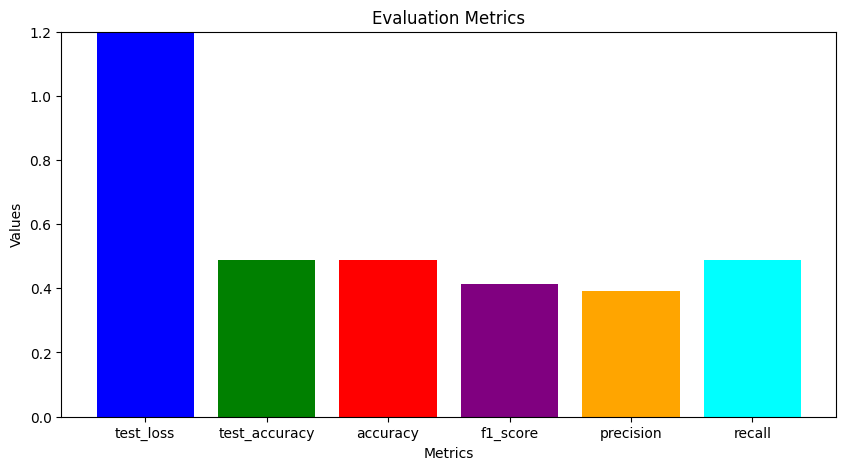

In [ ]:
def evaluate_lstm_model(model, test_texts, test_labels, label_map, num_classes):
    test_labels = test_labels.map(label_map)
    test_labels = to_categorical(test_labels, num_classes=num_classes)

    results = model.evaluate(test_texts, test_labels)
    print(f"Test Loss: {results[0]}")
    print(f"Test Accuracy: {results[1]}")

    predictions = model.predict(test_texts)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(test_labels, axis=1)
    accuracy = accuracy_score(true_classes, predicted_classes)
    f1 = f1_score(true_classes, predicted_classes, average='weighted')
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')

    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

    return {
        'test_loss': results[0],
        'test_accuracy': results[1],
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall
    }

def plot_evaluation_results(metrics):
    # Extract metrics
    labels = list(metrics.keys())
    values = list(metrics.values())

    # Plot metrics
    plt.figure(figsize=(10, 5))
    plt.bar(labels, values, color=['blue', 'green', 'red', 'purple', 'orange', 'cyan'])
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Evaluation Metrics')
    plt.ylim(0, 1.2)
    plt.show()

test_texts = np.array(TestData['X'])
test_labels = TestData['Y']

lstm_model = tf.keras.models.load_model('/content/drive/MyDrive/NLP/lstm_model')
metrics = evaluate_lstm_model(lstm_model, test_texts, test_labels, label_map, num_classes=len(labels))
plot_evaluation_results(metrics)